# Analyze MTurk MOS Scores

This repository analyzes MOS scores from MTurk.

TODO:
* Compute a confidence interval via the crowdMOS algorithm. The current confidence algorithm is more naive.

In [2]:
%matplotlib inline

from IPython.display import display
from IPython.display import Markdown

import pandas


# NOTE: This CSV can be downloaded from MTurk after recieving results from a batch.
data_frame = pandas.read_csv('../../data/Batch_3741977_batch_results (1).csv')
data_frame.columns

Index(['HITId', 'HITTypeId', 'Title', 'Description', 'Keywords', 'Reward',
       'CreationTime', 'MaxAssignments', 'RequesterAnnotation',
       'AssignmentDurationInSeconds', 'AutoApprovalDelayInSeconds',
       'Expiration', 'NumberOfSimilarHITs', 'LifetimeInSeconds',
       'AssignmentId', 'WorkerId', 'AssignmentStatus', 'AcceptTime',
       'SubmitTime', 'AutoApprovalTime', 'ApprovalTime', 'RejectionTime',
       'RequesterFeedback', 'WorkTimeInSeconds', 'LifetimeApprovalRate',
       'Last30DaysApprovalRate', 'Last7DaysApprovalRate', 'Input.index',
       'Input.audio_url', 'Input.example_index', 'Input.type',
       'Input.transcript', 'Input.speaker',
       'Input.signal_model_checkpoint_path',
       'Input.spectrogram_model_checkpoint_pat',
       'Input.spectrogram_model_batch_size', 'Input.is_aligned',
       'Input.is_balanced', 'Input.process_id', 'Answer.audio-naturalness',
       'Answer.audio-naturalness.label', 'Approve', 'Reject'],
      dtype='object')

In [3]:
# NOTE: Print unqiue batches of data, each set of samples has a random process id attached.
data_frame.groupby(['Input.process_id']).size()

Input.process_id
2724     220
3563     220
3652     220
3697     220
6824     220
19924    220
38361    220
dtype: int64

## Select Data Subset

In [19]:
# For convience, reload the `data_frame` each time.
data_frame = pandas.read_csv('../../data/Batch_3741977_batch_results (1).csv')

# Select a set of samples
data_frame = data_frame[data_frame['Input.process_id'] == 2724]

# Select none-gold samples
data_frame = data_frame # [data_frame['Input.type'] != 'gold']

# Select a subset of speakers
data_frame = data_frame[~data_frame['Input.speaker'].isin(['Judy Bieber', 'Mary Ann', 'Linda Johnson'])]

# Select a subset of workers. It's hard to tell if a worker has completed the task correctly. There are some useful 
# indicators though:
# - Did the worker complete the task faster than the length of the audio clip?
# - Did the worker rate the ground truth samples lower than the generated samples?
# - Were the workers average ratings significantly worse or better than the average ratings?
data_frame = data_frame[~data_frame['WorkerId'].isin(['A2COAUZ1TISD2Q', 'A347XXV5JH19PB'])]

# Select a subset of tasks that have not been rejected
data_frame = data_frame[~data_frame['Reject'].notnull()]

display(Markdown('Number of respones:'))
len(data_frame)

Number of respones:

137

## Compute and Analyze MOS Score

In [29]:
import math

def label_to_score(label):
    """ Get the MOS score from the MOS label.
    """
    tokens = label.lower().split()
    if 'excellent' in tokens:
        return 5.0
    elif 'good' in tokens:
        return 4.0
    elif 'fair' in tokens:
        return 3.0
    elif 'poor' in tokens:
        return 2.0
    elif 'bad' in tokens:
        return 1.0
    raise ValueError()

# NOTE: For some odd reason, Amazon uses two columns to represent the reponses of workers. We combine these columns
# here.
data_frame['MOS'] = data_frame[
    ['Answer.audio-naturalness.label', 'Answer.audio-naturalness']].apply(
    lambda r: r[0] if isinstance(r[0], str) else r[1], axis=1)

data_frame['MOS'] = data_frame['MOS'].apply(label_to_score)
display(Markdown('#### Mean Opinion Score (MOS)'))
data_frame['MOS'].describe()

#### Mean Opinion Score (MOS)

count    137.000000
mean       3.854015
std        0.996613
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: MOS, dtype: float64

In [26]:
import numpy as np 
import scipy.stats

def sample_mean_confidence_interval(data, confidence=0.95):
    """
    NOTE: This is a similar approach to computing a confidence interval as the Tacotron 2 approach.
    Inspired by: https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
    """
    data = np.array(data)
    a, b = scipy.stats.t.interval(confidence, len(data)-1, loc=np.mean(data), scale=scipy.stats.sem(data))
    return np.mean(data), (b - a) / 2

display(Markdown('#### 95 Percent Confidence Interval \n%f ± %f' % 
    sample_mean_confidence_interval(data_frame["MOS"].tolist())))

#### 95 Percent Confidence Interval 
3.854015 ± 0.168382

#### MOS Distribution

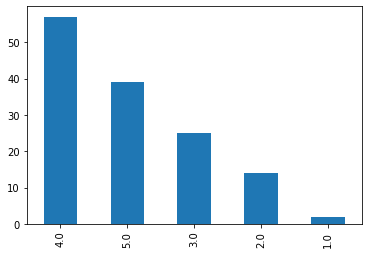

In [30]:
display(Markdown('#### MOS Distribution'))
pandas.value_counts(data_frame['MOS']).plot.bar()

In [31]:
display(Markdown('#### Speaker MOS Score Distribution'))
data_frame.groupby('Input.speaker')['MOS'].describe().sort_values(by=['mean'])

#### Speaker MOS Score Distribution

,count,mean,std,min,25%,50%,75%,max
Input.speaker,,,,,,,,
Beth Cameron (Custom),16.0,3.250000,1.125463,1.0,2.75,3.0,4.0,5.0
Susan Murphy,10.0,3.300000,1.159502,1.0,3.00,3.5,4.0,5.0
Beth Cameron,27.0,3.666667,1.000000,2.0,3.00,4.0,4.0,5.0
Sam Scholl,13.0,3.923077,0.954074,2.0,3.00,4.0,5.0,5.0
Adrienne Walker-Heller,20.0,4.000000,0.917663,2.0,4.00,4.0,5.0,5.0
Heather Doe,23.0,4.086957,0.848155,2.0,4.00,4.0,5.0,5.0
Frank Bonacquisti,12.0,4.166667,0.834847,3.0,3.75,4.0,5.0,5.0
Hilary Noriega,16.0,4.312500,0.873212,2.0,4.00,4.5,5.0,5.0


## Analyze Worker Integrity

In [33]:
# NOTE: It's important to have a number of unique workers to eliminate bias.
display(Markdown('#### Number of Workers'))
data_frame['WorkerId'].nunique()

#### Number of Workers

51

In [42]:
# NOTE: It may be useful to disregard workers who completed only one HIT. 
display(Markdown('#### Worker MOS Score Distribution (Sorted by Count)'))
data_frame.groupby('WorkerId')['MOS'].describe().sort_values(by=['count'])

#### Worker MOS Score Distribution (Sorted by Count)

,count,mean,std,min,25%,50%,75%,max
WorkerId,,,,,,,,
ATHS9GUME1XCA,1.0,5.000000,NaN,5.0,5.00,5.0,5.00,5.0
A2WNW8A4MOR7T7,1.0,4.000000,NaN,4.0,4.00,4.0,4.00,4.0
A2SLEMDA17XTZ1,1.0,2.000000,NaN,2.0,2.00,2.0,2.00,2.0
A3HII8DX9SINOU,1.0,5.000000,NaN,5.0,5.00,5.0,5.00,5.0
A3PFU4042GIQLE,1.0,5.000000,NaN,5.0,5.00,5.0,5.00,5.0
A2KK5BSM1BR0WR,1.0,4.000000,NaN,4.0,4.00,4.0,4.00,4.0
A2HJ24KADG1P6A,1.0,3.000000,NaN,3.0,3.00,3.0,3.00,3.0
A3TUJHF9LW3M8N,1.0,5.000000,NaN,5.0,5.00,5.0,5.00,5.0
A2WQTNO91C05GC,1.0,5.000000,NaN,5.0,5.00,5.0,5.00,5.0


In [38]:
# NOTE: It may be useful to disregard workers who had a substantially different ratings.
display(Markdown('#### Worker MOS Score Distribution (Sorted by MOS)'))
data_frame.groupby('WorkerId')['MOS'].describe().sort_values(by=['mean'])

#### Worker MOS Score Distribution (Sorted by MOS)

,count,mean,std,min,25%,50%,75%,max
WorkerId,,,,,,,,
A26VFMS3M1XWSX,3.0,1.666667,0.577350,1.0,1.50,2.0,2.00,2.0
A22DDO8NILSX6O,1.0,2.000000,NaN,2.0,2.00,2.0,2.00,2.0
A2SLEMDA17XTZ1,1.0,2.000000,NaN,2.0,2.00,2.0,2.00,2.0
AKSJ3C5O3V9RB,1.0,2.000000,NaN,2.0,2.00,2.0,2.00,2.0
A4CPMNA135GK4,1.0,2.000000,NaN,2.0,2.00,2.0,2.00,2.0
A1YSYI926BBOHW,3.0,2.333333,0.577350,2.0,2.00,2.0,2.50,3.0
A3S5AA4R3RIEEP,2.0,2.500000,0.707107,2.0,2.25,2.5,2.75,3.0
AG263U3LX899H,1.0,3.000000,NaN,3.0,3.00,3.0,3.00,3.0
A39EZ7V9T25RZO,3.0,3.000000,1.732051,1.0,2.50,4.0,4.00,4.0


In [ ]:
# NOTE: It may be useful to disregard workers that had a lower MOS for the generated clips than the ground truth.
display(Markdown('#### Worker MOS Score Distribution (Ground Truth vs Generated)'))
merged = pandas.merge(
    data_frame[data_frame['Input.type'] != 'gold'].groupby('WorkerId')['MOS'].describe()[['mean', 'count', 'std']],
    data_frame[data_frame['Input.type'] == 'gold'].groupby('WorkerId')['MOS'].describe()[['mean', 'count', 'std']], 
    on='WorkerId')
merged['gap'] = merged['mean_y'] - merged['mean_x']
merged.sort_values(by=['gap'])

### Analyze Worker Integrity Using Audio Length

We can get the length of each audio segment to learn more.

In [45]:
import requests

from functools import lru_cache

@lru_cache()
def get_audio_length(audio_url, bits=16, sample_rate=24000):
    """ Compute the audio length in seconds from `audio_url`.
    """
    response = requests.get(audio_url)
    return len(response.content) / sample_rate / bits * 4
    
# NOTE: This might take a long time. It'd benefit significantly from multithreading.
data_frame['audio_length'] = data_frame['Input.audio_url'].apply(get_audio_length)

In [46]:
import statistics
display(Markdown('Time to complete task (in minutes):'))
(data_frame["WorkTimeInSeconds"] / 60).describe()

Time to complete task (in minutes):

count    137.000000
mean       3.912409
std        4.671734
min        0.100000
25%        0.266667
50%        2.800000
75%        5.150000
max       22.033333
Name: WorkTimeInSeconds, dtype: float64

In [141]:
# NOTE: Based on the crowdMOS paper, it's useful to reject people that don't listen to the entire clip via
# the `WorkTimeInSeconds` metric.
display(Markdown('Fastest completion times (in seconds):'))
pandas.set_option('display.max_colwidth', -1)
data_frame['WorkTimeInSecondsPerAudioSecond'] = data_frame['WorkTimeInSeconds'] / data_frame['audio_length']
top = data_frame.sort_values(by=['WorkTimeInSecondsPerAudioSecond'])[:20]
top[['WorkTimeInSeconds', 'WorkerId', 'Input.audio_url', 'audio_length', 'WorkTimeInSecondsPerAudioSecond']]

Fastest completion times (in seconds):

,WorkTimeInSeconds,WorkerId,Input.audio_url,audio_length,WorkTimeInSecondsPerAudioSecond
1116,7,A2COAUZ1TISD2Q,https://storage.googleapis.com/mturk-samples/2019-08-20/5a4c293e3c0b3122.wav,12.050604,0.580884
1084,10,A2COAUZ1TISD2Q,https://storage.googleapis.com/mturk-samples/2019-08-20/5f16e74ce8e9ba8a.wav,11.225604,0.890821
1189,6,A2COAUZ1TISD2Q,https://storage.googleapis.com/mturk-samples/2019-08-20/-2be5b5a7b2dfd904.wav,6.144208,0.976529
908,6,A3TUJHF9LW3M8N,https://storage.googleapis.com/mturk-samples/2019-08-20/-3e1f83b8e14e0e49.wav,6.125604,0.979495
8,13,AG263U3LX899H,https://storage.googleapis.com/mturk-samples/2019-08-20/13806899910ed075.wav,11.663104,1.114626
1330,12,A2M5VW97GIYLHB,https://storage.googleapis.com/mturk-samples/2019-08-20/-69dac387c05ebccd.wav,10.325604,1.162160
1289,6,AN2IWKO1CAWS3,https://storage.googleapis.com/mturk-samples/2019-08-20/4a8547ab089bceff.wav,4.912958,1.221260
58,6,AITP2LUW8GPB,https://storage.googleapis.com/mturk-samples/2019-08-20/-3b3c92497560a347.wav,4.712958,1.273086
438,6,AN2IWKO1CAWS3,https://storage.googleapis.com/mturk-samples/2019-08-20/-4c9ebcb875aec262.wav,4.594208,1.305992
1200,15,A347XXV5JH19PB,https://storage.googleapis.com/mturk-samples/2019-08-20/caa54807339baad.wav,11.475604,1.307121


## Correlate Audio Length with MOS Score

MOS by audio length:

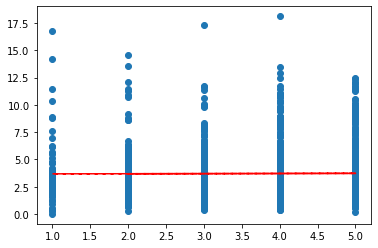

In [155]:
# NOTE: There may be a correlation of audio length to MOS score.
import matplotlib.pyplot as pyplot
import numpy as np

display(Markdown('MOS by audio length:'))

x = data_frame['MOS']
y = data_frame['audio_length']
pyplot.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
pyplot.plot(x, p(x), "r--")

## Get Task Completion Time

It's useful to guage the time it takes to compelete a task to determine fair worker pay.

Density of time taken to complete a task:

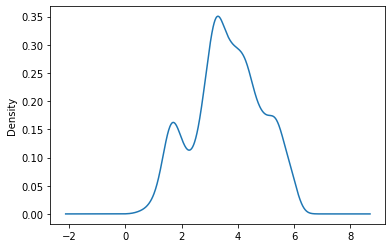

In [156]:
# NOTE: This may be useful for determining the time taken to complete a task.
display(Markdown('Density of time taken to complete a task:'))
# NOTE: Remove outliers.
# For example, it doesn't make sense to take 250 (4 minutes) seconds to review a 10 second clip. Workers that take
# so long to complete a task, may be working on multiple tasks at a time.
# NOTE (Michael 07-25-2019): From a previous analysis it looks like many workers are able to complete a task in
# 3 - 4x the audio time.
most_time = data_frame['WorkTimeInSecondsPerAudioSecond'][data_frame['WorkTimeInSecondsPerAudioSecond'] < 6]
most_time.plot.kde(bw_method=0.2)